<a href="https://colab.research.google.com/github/microsoft/FLAML/blob/main/notebook/autogen_agent_auto_feedback_from_code_execution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interactive LLM Agent with Auto Feedback from Code Execution

FLAML offers an experimental feature of interactive LLM agents, which can be used to solve various tasks with human or automatic feedback, including tasks that require using tools via code.

In this notebook, we demonstrate how to use `AssistantAgent` and `UserProxyAgent` to write code and execute the code. Here `AssistantAgent` is an LLM-based agent that can write Python code (in a Python coding block) for a user to execute for a given task. `UserProxyAgent` is an agent which serves as a proxy for the human user to execute the code written by `AssistantAgent`, or automatically execute the code. Depending on the setting of `human_input_mode` and `max_consecutive_auto_reply`, the `UserProxyAgent` either solicits feedback from the human user or uses auto-feedback based on the result of code execution. For example, when `human_input_mode` is set to "ALWAYS", the `UserProxyAgent` will always prompt the user for feedback. When user feedback is provided, the `UserProxyAgent` will directly pass the feedback to `AssistantAgent` without doing any additional steps. When no user feedback is provided, the `UserProxyAgent` will execute the code written by `AssistantAgent` directly and return the execution results (success or failure and corresponding outputs) to `AssistantAgent`.

## Requirements

FLAML requires `Python>=3.7`. To run this notebook example, please install flaml with the [autogen] option:
```bash
pip install flaml[autogen]
```

In [1]:
# %pip install flaml[autogen]

## Set your API Endpoint

The [`config_list_gpt4_gpt35`](https://microsoft.github.io/FLAML/docs/reference/autogen/oai/openai_utils#config_list_gpt4_gpt35) function tries to create a list of gpt-4 and gpt-3.5 configurations using Azure OpenAI endpoints and OpenAI endpoints. It assumes the api keys and api bases are stored in the corresponding environment variables or local txt files:

- OpenAI API key: os.environ["OPENAI_API_KEY"] or `openai_api_key_file="key_openai.txt"`.
- Azure OpenAI API key: os.environ["AZURE_OPENAI_API_KEY"] or `aoai_api_key_file="key_aoai.txt"`. Multiple keys can be stored, one per line.
- Azure OpenAI API base: os.environ["AZURE_OPENAI_API_BASE"] or `aoai_api_base_file="base_aoai.txt"`. Multiple bases can be stored, one per line.

It's OK to have only the OpenAI API key, or only the Azure OpenAI API key + base.


In [2]:
from flaml import oai

config_list = oai.config_list_from_models(model_list=["gpt-4"])

The config list looks like the following:
```python
config_list = [
    {
        'model': 'gpt-4',
        'api_key': '<your OpenAI API key here>',
    },  # only if OpenAI API key is found
    {
        'model': 'gpt-4',
        'api_key': '<your first Azure OpenAI API key here>',
        'api_base': '<your first Azure OpenAI API base here>',
        'api_type': 'azure',
        'api_version': '2023-03-15-preview',
    },  # only if the at least one Azure OpenAI API key is found
    {
        'model': 'gpt-4',
        'api_key': '<your second Azure OpenAI API key here>',
        'api_base': '<your second Azure OpenAI API base here>',
        'api_type': 'azure',
        'api_version': '2023-03-15-preview',
    },  # only if the second Azure OpenAI API key is found
    {
        'model': 'gpt-3.5-turbo',
        'api_key': '<your OpenAI API key here>',
    },  # only if OpenAI API key is found
    {
        'model': 'gpt-3.5-turbo',
        'api_key': '<your first Azure OpenAI API key here>',
        'api_base': '<your first Azure OpenAI API base here>',
        'api_type': 'azure',
        'api_version': '2023-03-15-preview',
    },  # only if the at least one Azure OpenAI API key is found
    {
        'model': 'gpt-3.5-turbo',
        'api_key': '<your second Azure OpenAI API key here>',
        'api_base': '<your second Azure OpenAI API base here>',
        'api_type': 'azure',
        'api_version': '2023-03-15-preview',
    },  # only if the second Azure OpenAI API key is found
]
```

You can directly override it if the above function returns an empty list, i.e., it doesn't find the keys in the specified locations.

## Example Task: Write Code to Draw a Plot

In the example below, let's see how to use the agents in FLAML to write a python script and execute the script. This process involves constructing a `AssistantAgent` to serve as the assistant, along with a `UserProxyAgent` that acts as a proxy for the human user. In this example demonstrated below, when constructing the `UserProxyAgent`,  we select the `human_input_mode` to "NEVER". This means that the `UserProxyAgent` will not solicit feedback from the human user. It stops replying when the limit defined by `max_consecutive_auto_reply` is reached, or when `is_termination_msg()` returns true for the received message.

In [3]:
from flaml.autogen.agent.assistant_agent import AssistantAgent
from flaml.autogen.agent.user_proxy_agent import UserProxyAgent

# create an assistant which is essentially a AssistantAgent instance named "coding_agent"
assistant = AssistantAgent("assistant", request_timeout=600, seed=42, config_list=config_list)
# create a UserProxyAgent instance named "user"
user = UserProxyAgent(
    "user",
    human_input_mode="NEVER",
    max_consecutive_auto_reply=10,
    is_termination_msg=lambda x: x.rstrip().endswith("TERMINATE") or x.rstrip().endswith('"TERMINATE".'),
    work_dir=".",
)
# the assistant receives a message from the user, which contains the task description
assistant.receive(
    """Plot a rocket and save the plot to a file named 'rocket.svg'""",
    user,
)


**** assistant received message from user ****

Plot a rocket and save the plot to a file named 'rocket.svg'

**** user received message from assistant ****

To plot a rocket and save it to an SVG file, you'll need to install the `matplotlib` library if you haven't already:

```bash
pip install matplotlib
```

Now, use the code snippet below to plot a simple rocket and save it as 'rocket.svg':
```python
import matplotlib.pyplot as plt

def plot_rocket():
    plt.figure(figsize=(4, 10))
    
    # Rocket body
    plt.plot([0, 0], [0, 8], 'b-', linewidth=12)
    
    # Rocket head
    plt.plot([-0.5, 0, 0.5], [8, 9, 8], 'b-', linewidth=12, solid_capstyle='round')
    
    # Rocket fins
    plt.plot([0, -1.5], [2, 0], 'b-', linewidth=4, solid_capstyle='round')
    plt.plot([0, 1.5], [2, 0], 'b-', linewidth=4, solid_capstyle='round')
    
    plt.xlim(-2, 2)
    plt.ylim(0, 9.5)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.axis('off')
    
    plt.savefig('rocket.svg', form

The example above involves code execution. In FLAML, code execution is triggered automatically by the `UserProxyAgent` when it detects an executable code block in a received message and no human user input is provided. This process occurs in a designated working directory, using a Docker container by default. Unless a specific directory is specified, FLAML defaults to the `flaml/autogen/extensions` directory. Users have the option to specify a different working directory by setting the `work_dir` argument when constructing a new instance of the `UserProxyAgent`.

Let's display the generated figure.

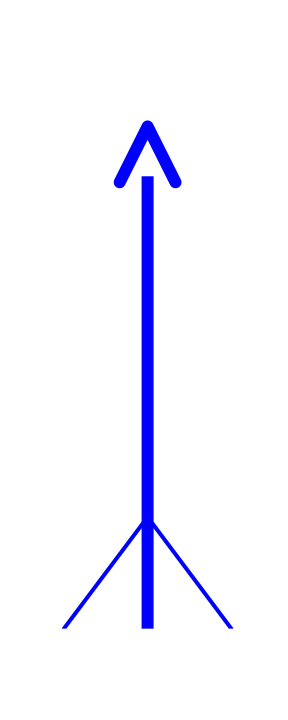

In [4]:
# uncomment the following to render the svg file
# from IPython.display import SVG, display

# display(SVG("rocket.svg"))

## Example Task: Use Code to Check Stock Price Change

In [6]:
# it is suggested to reset the assistant to clear the state if the new task is not related to the previous one.
assistant.reset()
assistant.receive(
    """What date is today? Which S&P stock has the largest year-to-date gain in 2023? How much is the gain""",
    user,
)


**** assistant received message from user ****

What date is today? Which S&P stock has the largest year-to-date gain in 2023? How much is the gain

**** user received message from assistant ****

To get today's date, you can use the following code:

```python
from datetime import datetime

today = datetime.now().strftime("%Y-%m-%d")
print(f"Today's date is {today}")
```

As for fetching the S&P stock with the largest year-to-date gain in 2023, we first need to check the stock data. Run the code below to install the necessary library:

```python
!pip install yfinance
```

Once the library is installed, use the following code to retrieve the S&P 500 stock data:

```python
import yfinance as yf
import pandas as pd
from datetime import datetime

def get_sp500_tickers():
    table = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
    return table['Symbol'].tolist()

def ytd_stock_gains(year):
    start_date = f"{year}-01-01"
    end_date = datetime.now().strft

All the feedback is auto generated.